# Deep Learning Challenge - Training
## Michelle Rohrer

Dieses Notebook enthält alle Trainings.

### Pakete laden

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import wandb
from dotenv import load_dotenv
import pickle

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from src.plots import (
    plot_training_curves,
    plot_hyperparameter_comparison,
    plot_hyperparameter_performance_summary
)
from src.model import BaselineCNN
from src.test_train import (
    train_model,
    hyperparameter_tuning_with_wandb
)
from src.evaluation import (
    cross_validation_training
)

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")


WanDB Key erfolgreich geladen


### Daten laden


In [ ]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

img_size = 48
batch_size = 64

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen mit Multi-Core Optimierung für M5
# Optimale Worker-Anzahl: Anzahl Cores - 1 (für Multi-Processing)
import multiprocessing
optimal_workers = max(1, multiprocessing.cpu_count() - 1)
print(f"Verwende {optimal_workers} Worker für DataLoader (von {multiprocessing.cpu_count()} Cores)")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=True  # Beschleunigt Transfer zu MPS/GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=True
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


### Training des Basismodells

**Zweck:** Automatisches Tracking aller Experimente für bessere Reproduzierbarkeit und Analyse.

**Was wird getrackt:**
- **Hyperparameter:** Lernrate, Batch-Größe, Optimizer-Einstellungen
- **Metriken:** Training/Validation Loss und Accuracy pro Epoche
- **Test-Metriken:** Accuracy, Precision, Recall, F1-Score, Top-K Accuracy


In [ ]:
# wandb Setup
# wandb API Key aus .env laden
wandb_key = os.getenv('KEY')
if wandb_key:
    wandb.login(key=wandb_key)
    print("wandb erfolgreich authentifiziert")
else:
    print("wandb API Key nicht in .env gefunden")

# Device Setup: MPS (Apple Silicon) > CUDA > CPU
device = torch.device("mps" if torch.backends.mps.is_available() 
                     else "cuda" if torch.cuda.is_available() 
                     else "cpu")
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
num_classes = len(full_train_dataset.class_to_idx)
print(f"Klassen: {class_names}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\MichelleRohrer\_netrc
wandb: Currently logged in as: michelle-rohrer (michelle-rohrer-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb erfolgreich authentifiziert
Verwende Device: cpu
Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


=== Training des Basismodells ===
Konfiguration: SGD (momentum=0), LR=0.01, Batch=64, 200 Epochen


Training startet: 200 Epochen, LR=0.01, Batch=64
Early Stopping: patience=20, min_delta=0.001
------------------------------------------------------------
Epoch   1/200 | Train Loss: 1.8526 | Val Loss: 1.8091 | Train Acc: 23.88% | Val Acc: 25.06% | Patience: 0/20
Epoch   5/200 | Train Loss: 1.8056 | Val Loss: 1.7963 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/20
Epoch  10/200 | Train Loss: 1.7598 | Val Loss: 1.7521 | Train Acc: 27.40% | Val Acc: 27.19% | Patience: 0/20
Epoch  15/200 | Train Loss: 1.6844 | Val Loss: 1.6630 | Train Acc: 33.61% | Val Acc: 35.28% | Patience: 0/20
Epoch  20/200 | Train Loss: 1.6133 | Val Loss: 1.6086 | Train Acc: 37.72% | Val Acc: 36.82% | Patience: 0/20
Epoch  25/200 | Train Loss: 1.5559 | Val Loss: 1.5809 | Train Acc: 40.08% | Val Acc: 38.14% | Patience: 0/20
Epoch  30/200 | Train Loss: 1.5000 | Val Loss: 1.5160 | Train Acc: 42.33% | Val Acc: 40.91% | Patience: 0/20
Epoch  35/200 | Train Loss: 1.4414 | Val Loss: 1.4769 | Train Acc: 45.01% | Val Ac

best_val_loss,█████▇▇▇▇▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▂▃▄▁▁▂▂▅▅▆▆█
train_acc,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
train_loss,███▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
val_acc,▁▁▁▁▂▄▅▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇████▇███▇██
val_loss,█████▇▇▇▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▃▄▄▄▅
best_val_loss,1.40982
epoch,79
patience_counter,20
train_acc,71.64628


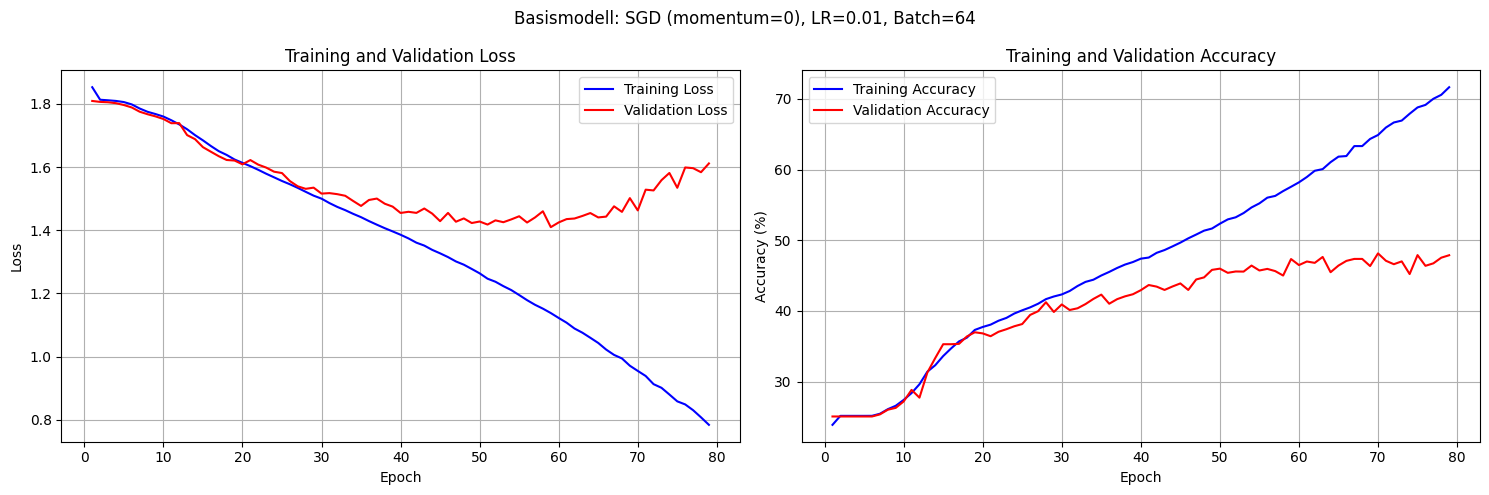

Basismodell gespeichert als 'models/baseline_model.pth'


In [ ]:
# Basismodell erstellen und trainieren
print("=== Training des Basismodells ===")
print("Konfiguration: SGD (momentum=0), LR=0.01, Batch=64, 60 Epochen")
print("Hinweis: Modell wird aus Code initialisiert (nicht geladen) und nach Epoche 60 automatisch gespeichert.")

# Modell initialisieren aus Code (nicht aus gespeichertem State)
# Dies stellt sicher, dass das Modell mit den aktuellen Einstellungen trainiert wird
model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Sicherstellen, dass models Verzeichnis existiert
os.makedirs('models', exist_ok=True)

# Training durchführen mit wandb
# Das Modell wird automatisch nach Epoche 60 gespeichert (siehe train_model Funktion)
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,  # Epoche 60 als Referenz
    learning_rate=0.01,
    batch_size=64,
    use_wandb=True,
    run_name="baseline_model",
    early_stopping=True,
    patience=20,
    min_delta=0.001,
    save_path='models/baseline_model_epoch60.pth'  # Automatisches Speichern nach Epoche 60
)

# Finales Modell speichern (nach allen Epochen)
torch.save(model.state_dict(), 'models/baseline_model.pth')
print("Basismodell gespeichert als 'models/baseline_model.pth'")
print(f"Finale Metriken - Accuracy: {val_accs[-1]:.2f}%, F1-Score: {val_f1s[-1]:.4f}")

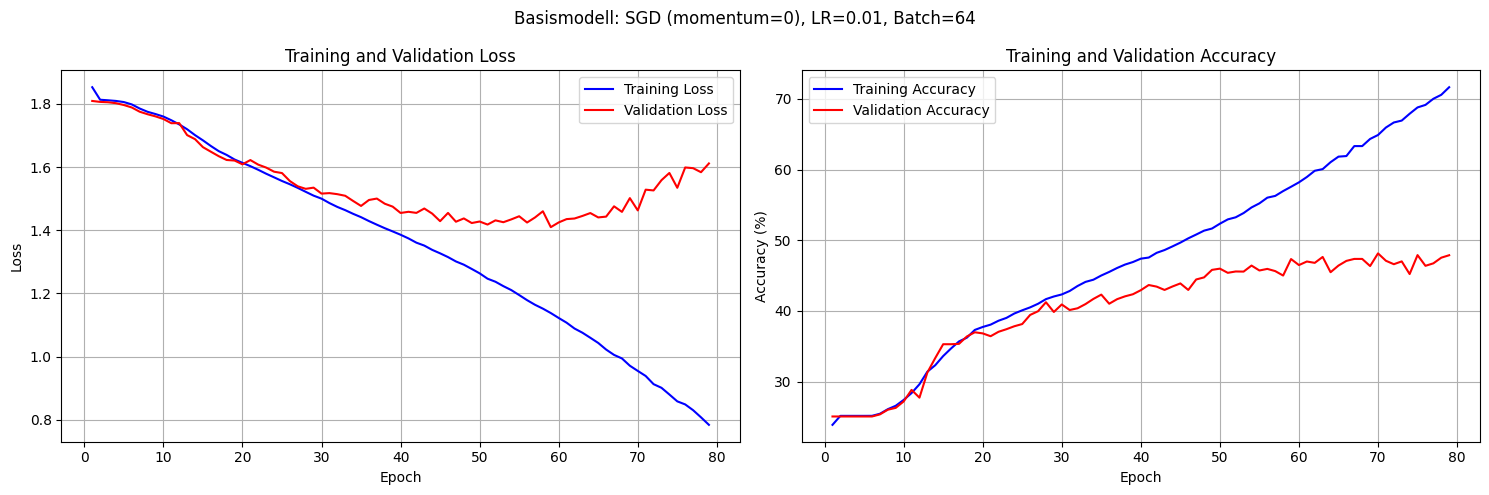

In [ ]:
# Lernkurven plotten und speichern
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                          title="Basismodell: SGD (momentum=0), LR=0.01, Batch=64")

# Plot als Bild speichern
fig.savefig('plots/baseline_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Lernkurven gespeichert als 'plots/baseline_training_curves.png'")

### Hyperparameter-Tuning

**Ziel:** Vergleich verschiedener Lernraten und Batch-Größen anhand der Lernkurven und Metriken.

**Testkonfigurationen:**
- **Lernraten:** [0.001, 0.01, 0.1]
- **Batch-Größen:** [16, 32, 64]
- **Epochen:** 60 (konsistent mit Baseline-Training)
- **Optimizer:** SGD ohne Momentum

**Hinweis:** Bei kleinen Datasets wird das Training automatisch beschleunigt.


In [ ]:
# Hyperparameter-Tuning mit wandb Integration
print("=== Hyperparameter-Tuning ===")

# Testkonfigurationen
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64] 
num_epochs = 60  # Konsistent mit Baseline-Training (Epoche 60 als Referenz)

# Hyperparameter-Tuning mit wandb durchführen
# Modell-Klasse wird als Parameter übergeben (nicht hardcodiert)
results = hyperparameter_tuning_with_wandb(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_epochs=num_epochs,
    img_size=img_size,
    num_classes=num_classes
)


=== Hyperparameter-Tuning mit wandb ===
=== Hyperparameter-Tuning mit wandb ===
Teste 3 Lernraten × 3 Batch-Größen = 9 Konfigurationen

--- LR_0.001_Batch_16 ---


Training startet: 50 Epochen, LR=0.001, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.9041 | Val Loss: 1.8642 | Train Acc: 21.97% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.8120 | Val Loss: 1.8059 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  10/50 | Train Loss: 1.8062 | Val Loss: 1.7996 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.7855 | Val Loss: 1.7782 | Train Acc: 25.28% | Val Acc: 25.15% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.7567 | Val Loss: 1.7497 | Train Acc: 28.19% | Val Acc: 27.92% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.7286 | Val Loss: 1.7218 | Train Acc: 30.40% | Val Acc: 30.60% | Patience: 0/8
Epoch  30/50 | Train Loss: 1.6960 | Val Loss: 1.6831 | Train Acc: 32.91% | Val Acc: 33.72% | Patience: 0/8
Epoch  35/50 | Train Loss: 1.6576 | Val Loss: 1.6673 | Train Acc: 35.08% | Val Acc: 33.61% | Pati

best_val_loss,█▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
patience_counter,▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁█▁█▁▁█▁▁▁█▁█▁█▁█▁
train_acc,▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,█▇▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▅▇▆▇▇▇▇▇█▇██
val_loss,█▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▁▂▁▂▁
best_val_loss,1.56806
epoch,50
patience_counter,0
train_acc,39.80494


Finale Validation Accuracy: 39.17%
Finale Validation Loss: 1.5681

--- LR_0.001_Batch_32 ---


Training startet: 50 Epochen, LR=0.001, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.9113 | Val Loss: 1.8596 | Train Acc: 19.40% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.8132 | Val Loss: 1.8069 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  10/50 | Train Loss: 1.8116 | Val Loss: 1.8054 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 4/8
Epoch  15/50 | Train Loss: 1.8098 | Val Loss: 1.8036 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.8069 | Val Loss: 1.8009 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.8004 | Val Loss: 1.7943 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  30/50 | Train Loss: 1.7857 | Val Loss: 1.7812 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  35/50 | Train Loss: 1.7729 | Val Loss: 1.7706 | Train Acc: 26.17% | Val Acc: 25.50% | Pati

best_val_loss,█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▁▃▁▅▆█▁▃▆▁▃▅▁▁▃▁▃▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▃▁▁▁▁▁
train_acc,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▄▄▄▄▅▅▆▆▇█
val_loss,█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
best_val_loss,1.73672
epoch,50
patience_counter,0
train_acc,29.3421


Finale Validation Accuracy: 28.68%
Finale Validation Loss: 1.7367

--- LR_0.001_Batch_64 ---


Training startet: 50 Epochen, LR=0.001, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.9499 | Val Loss: 1.9386 | Train Acc: 12.39% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.8601 | Val Loss: 1.8455 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.8143 | Val Loss: 1.8081 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.8125 | Val Loss: 1.8063 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 3/8
Epoch  20/50 | Train Loss: 1.8118 | Val Loss: 1.8057 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  25/50 | Train Loss: 1.8111 | Val Loss: 1.8050 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 6/8
Epoch  30/50 | Train Loss: 1.8102 | Val Loss: 1.8043 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 3/8
Epoch  35/50 | Train Loss: 1.8091 | Val Loss: 1.8034 | Train Acc: 25.15% | Val Acc: 25.06% | Pati

best_val_loss,█▇▆▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▂▁▃▅▆▇█▂▃▅▆█▁▂▃▅▆▁▂▃▅▆▂▃▅▁▂▁▂▃▁▁
train_acc,▁███████████████████████████████████████
train_loss,█▇▆▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,1.7973
epoch,50
patience_counter,0
train_acc,25.14913


Finale Validation Accuracy: 25.06%
Finale Validation Loss: 1.7973

--- LR_0.01_Batch_16 ---


Training startet: 50 Epochen, LR=0.01, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8258 | Val Loss: 1.8056 | Train Acc: 24.81% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.6947 | Val Loss: 1.6672 | Train Acc: 32.42% | Val Acc: 34.62% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.4823 | Val Loss: 1.4673 | Train Acc: 43.00% | Val Acc: 43.61% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.3076 | Val Loss: 1.4022 | Train Acc: 49.92% | Val Acc: 46.74% | Patience: 2/8
Epoch  20/50 | Train Loss: 1.1150 | Val Loss: 1.3466 | Train Acc: 57.94% | Val Acc: 49.37% | Patience: 3/8
Epoch  25/50 | Train Loss: 0.8899 | Val Loss: 1.3651 | Train Acc: 67.61% | Val Acc: 51.06% | Patience: 3/8
Epoch  30/50 | Train Loss: 0.6379 | Val Loss: 1.7124 | Train Acc: 76.68% | Val Acc: 50.12% | Patience: 8/8

Early Stopping nach 30 Epochen!
Beste Validation Loss: 1.3224 in Epoche 22


best_val_loss,██▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▂▁▁▂▃▁▁▂▃▄▅▁▂▃▄▅▅▆▇█
train_acc,▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
train_loss,████▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
val_acc,▁▁▁▂▄▄▄▅▆▆▅▆▇▆▇▇▇█▇██████▇▇▇▇█
val_loss,██▇▇▆▅▅▄▄▃▄▃▂▂▂▂▁▁▁▁▁▁▂▂▂▃▄▄▅▇
best_val_loss,1.32236
epoch,30
patience_counter,8
train_acc,76.68394


Finale Validation Accuracy: 50.12%
Finale Validation Loss: 1.7124

--- LR_0.01_Batch_32 ---


Training startet: 50 Epochen, LR=0.01, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8313 | Val Loss: 1.8069 | Train Acc: 24.95% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.7493 | Val Loss: 1.7312 | Train Acc: 28.50% | Val Acc: 29.33% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.6054 | Val Loss: 1.5906 | Train Acc: 37.64% | Val Acc: 38.35% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.4933 | Val Loss: 1.5202 | Train Acc: 42.50% | Val Acc: 40.93% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.3853 | Val Loss: 1.4356 | Train Acc: 47.05% | Val Acc: 44.65% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.2751 | Val Loss: 1.3990 | Train Acc: 51.55% | Val Acc: 45.86% | Patience: 0/8
Epoch  30/50 | Train Loss: 1.1491 | Val Loss: 1.3899 | Train Acc: 56.79% | Val Acc: 47.72% | Patience: 1/8
Epoch  35/50 | Train Loss: 1.0116 | Val Loss: 1.3907 | Train Acc: 62.69% | Val Acc: 48.75% | Patie

best_val_loss,███▇▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▃▁▂▃▁▁▂▃▄▅▅▆▇█
train_acc,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
val_acc,▁▁▁▂▂▃▃▄▄▅▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇█████
val_loss,███▇▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▂▂
best_val_loss,1.36363
epoch,37
patience_counter,8
train_acc,64.88005


Finale Validation Accuracy: 48.26%
Finale Validation Loss: 1.4522

--- LR_0.01_Batch_64 ---


Training startet: 50 Epochen, LR=0.01, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8529 | Val Loss: 1.8097 | Train Acc: 23.85% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.7863 | Val Loss: 1.7770 | Train Acc: 25.29% | Val Acc: 25.34% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.7281 | Val Loss: 1.7103 | Train Acc: 30.47% | Val Acc: 30.29% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.6403 | Val Loss: 1.6343 | Train Acc: 36.09% | Val Acc: 36.07% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.5714 | Val Loss: 1.5732 | Train Acc: 39.32% | Val Acc: 38.26% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.5104 | Val Loss: 1.5309 | Train Acc: 41.67% | Val Acc: 40.20% | Patience: 1/8
Epoch  30/50 | Train Loss: 1.4490 | Val Loss: 1.4775 | Train Acc: 44.42% | Val Acc: 42.63% | Patience: 0/8
Epoch  35/50 | Train Loss: 1.3864 | Val Loss: 1.4311 | Train Acc: 47.14% | Val Acc: 44.86% | Patie

best_val_loss,████▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
patience_counter,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▃▁▁▁▃█▁▃▁▃▃▆█▃█
train_acc,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
val_acc,▁▁▁▁▁▂▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█▇████
val_loss,████▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
best_val_loss,1.38428
epoch,50
patience_counter,3
train_acc,56.03257


Finale Validation Accuracy: 47.65%
Finale Validation Loss: 1.3996

--- LR_0.1_Batch_16 ---


Training startet: 50 Epochen, LR=0.1, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.7691 | Val Loss: 1.6906 | Train Acc: 27.40% | Val Acc: 31.10% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.2724 | Val Loss: 1.3413 | Train Acc: 51.16% | Val Acc: 49.04% | Patience: 0/8
Epoch  10/50 | Train Loss: 0.9361 | Val Loss: 1.5331 | Train Acc: 64.74% | Val Acc: 48.76% | Patience: 4/8

Early Stopping nach 14 Epochen!
Beste Validation Loss: 1.3223 in Epoche 6


best_val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
patience_counter,▁▁▁▁▁▁▂▃▄▅▅▆▇█
train_acc,▁▃▄▄▅▅▆▆▆▇▇▇██
train_loss,█▇▆▅▅▄▄▃▃▂▂▂▁▁
val_acc,▁▄▆▇▇█▇██▇▆█▇▅
val_loss,▆▄▂▂▁▁▄▃▂▄▅▅▅█
best_val_loss,1.32229
epoch,14
patience_counter,8
train_acc,72.91331


Finale Validation Accuracy: 43.07%
Finale Validation Loss: 1.8817

--- LR_0.1_Batch_32 ---


Training startet: 50 Epochen, LR=0.1, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.7978 | Val Loss: 1.7578 | Train Acc: 25.78% | Val Acc: 27.10% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.3336 | Val Loss: 1.3455 | Train Acc: 48.82% | Val Acc: 48.50% | Patience: 0/8
Epoch  10/50 | Train Loss: 0.9346 | Val Loss: 1.3408 | Train Acc: 65.14% | Val Acc: 51.81% | Patience: 2/8
Epoch  15/50 | Train Loss: 0.5609 | Val Loss: 1.8444 | Train Acc: 79.74% | Val Acc: 48.55% | Patience: 7/8

Early Stopping nach 16 Epochen!
Beste Validation Loss: 1.3048 in Epoche 8


best_val_loss,█▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
patience_counter,▁▁▁▁▁▂▃▁▂▃▄▅▅▆▇█
train_acc,▁▂▃▃▄▄▅▅▅▆▆▇▇▇██
train_loss,█▇▇▆▅▅▅▄▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██▇▇█▇▇▇
val_loss,▇▄▃▂▂▂▂▁▁▁▃▄▅▆██
best_val_loss,1.30481
epoch,16
patience_counter,8
train_acc,81.83481


Finale Validation Accuracy: 49.11%
Finale Validation Loss: 1.8735

--- LR_0.1_Batch_64 ---


Training startet: 50 Epochen, LR=0.1, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8003 | Val Loss: 1.7639 | Train Acc: 25.33% | Val Acc: 27.71% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.4694 | Val Loss: 1.4403 | Train Acc: 43.15% | Val Acc: 43.59% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.1720 | Val Loss: 1.3578 | Train Acc: 55.69% | Val Acc: 48.14% | Patience: 2/8
Epoch  15/50 | Train Loss: 0.8589 | Val Loss: 1.4413 | Train Acc: 68.22% | Val Acc: 50.49% | Patience: 3/8
Epoch  20/50 | Train Loss: 0.5138 | Val Loss: 1.8800 | Train Acc: 81.14% | Val Acc: 51.38% | Patience: 8/8

Early Stopping nach 20 Epochen!
Beste Validation Loss: 1.3169 in Epoche 12


best_val_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
patience_counter,▁▁▁▁▁▁▁▁▂▃▄▁▂▃▄▅▅▆▇█
train_acc,▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇▇▇███▇██████
val_loss,▇▅▄▃▃▂▂▁▁▂▁▁▁▃▃▃▄▆▇█
best_val_loss,1.3169
epoch,20
patience_counter,8
train_acc,81.14251


Finale Validation Accuracy: 51.38%
Finale Validation Loss: 1.8800

=== Hyperparameter-Tuning abgeschlossen ===
Alle Experimente wurden in wandb gespeichert!


In [ ]:
# Visualisierung der Hyperparameter-Ergebnisse
print("=== Hyperparameter-Vergleich ===")

# Zusammenfassung der Ergebnisse mit F1-Score und bester Performance
summary_data = []
for config_key, result in results.items():
    summary_data.append({
        'Learning Rate': result['learning_rate'],
        'Batch Size': result['batch_size'],
        'Final Train Acc (%)': result['final_train_acc'],
        'Final Val Acc (%)': result['final_val_acc'],
        'Best Val Acc (%)': result.get('best_val_acc', result['final_val_acc']),
        'Final Train F1': result.get('final_train_f1', 0),
        'Final Val F1': result.get('final_val_f1', 0),
        'Best Val F1': result.get('best_val_f1', result.get('final_val_f1', 0)),
        'Final Train Loss': result['final_train_loss'],
        'Final Val Loss': result['final_val_loss'],
        'Epochen': result.get('num_epochs', result.get('best_epoch', len(result.get('val_accs', []))))
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Best Val Acc (%)', ascending=False)

print("Ergebnisse sortiert nach bester Validation Accuracy:")
print(df_summary[['Learning Rate', 'Batch Size', 'Best Val Acc (%)', 'Best Val F1', 'Final Val Acc (%)', 'Final Val F1', 'Epochen']].to_string(index=False))

# Beste Konfiguration finden
best_config = df_summary.iloc[0]
print(f"\nBeste Konfiguration:")
print(f"Learning Rate: {best_config['Learning Rate']}")
print(f"Batch Size: {best_config['Batch Size']}")
print(f"Beste Validation Accuracy: {best_config['Best Val Acc (%)']:.2f}% (Epoche {best_config['Epochen']})")
print(f"Beste Validation F1-Score: {best_config['Best Val F1']:.4f}")
print(f"Finale Validation Accuracy: {best_config['Final Val Acc (%)']:.2f}%")
print(f"Finale Validation F1-Score: {best_config['Final Val F1']:.4f}")


=== Hyperparameter-Vergleich ===
Ergebnisse sortiert nach Validation Accuracy:
 Learning Rate  Batch Size  Final Train Acc (%)  Final Val Acc (%)  Final Train Loss  Final Val Loss
         0.100          64            81.142509          51.375827          0.513771        1.880038
         0.010          16            76.683938          50.121909          0.637864        1.712376
         0.100          32            81.834806          49.111808          0.509277        1.873528
         0.010          32            64.880045          48.258447          0.953613        1.452223
         0.010          64            56.032568          47.648903          1.176764        1.399568
         0.100          16            72.913310          43.068617          0.740427        1.881738
         0.001          16            39.804938          39.167537          1.568298        1.568062
         0.001          32            29.342100          28.683386          1.739914        1.736720
         0.0

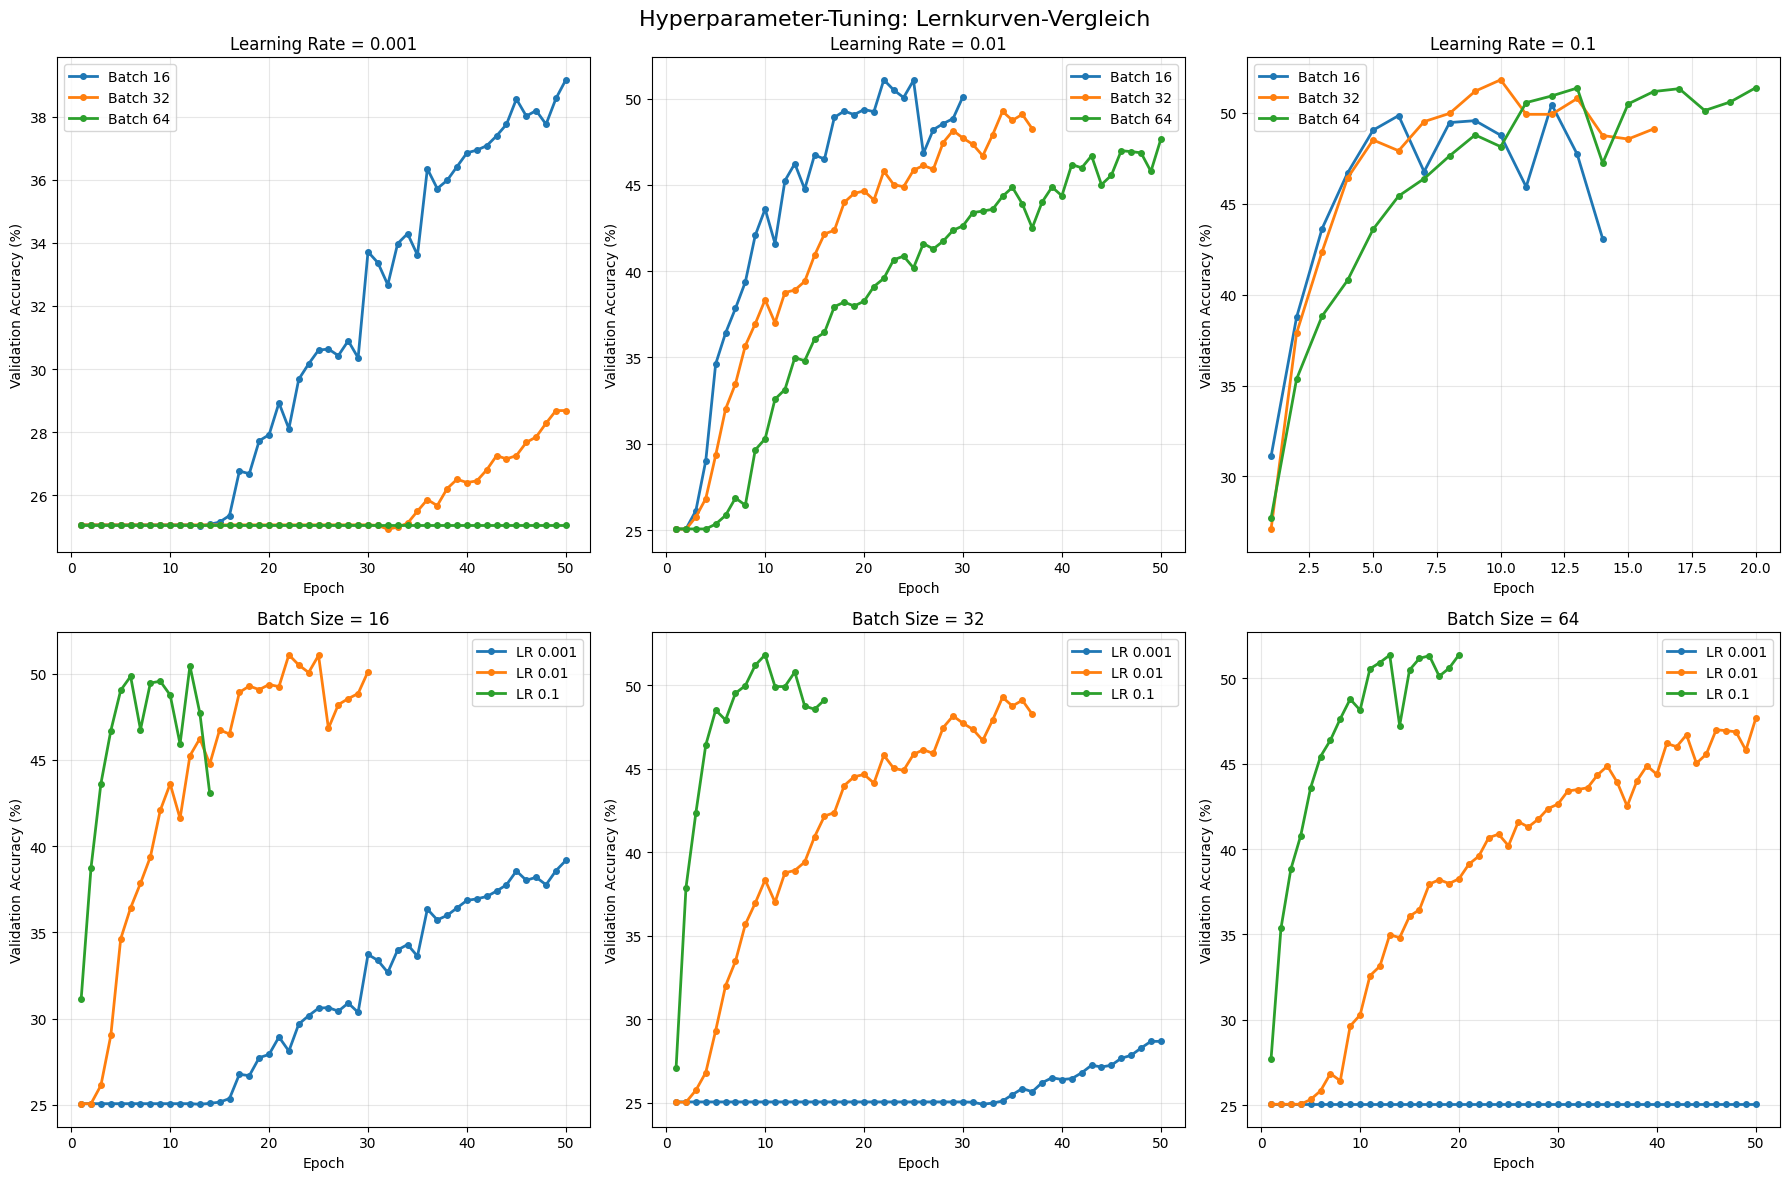

In [ ]:
# Lernkurven-Vergleich für verschiedene Konfigurationen (mit Trainingskurven)
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_hyperparameter_comparison(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_comparison.png'
)

# Performance-Übersicht mit Accuracy, F1-Score, LR und Epochen
fig_perf = plot_hyperparameter_performance_summary(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_performance_summary.png'
)

print("Hyperparameter-Plots gespeichert:")
print("  - plots/hyperparameter_comparison.png")
print("  - plots/hyperparameter_performance_summary.png")


### Cross-Validation für statistische Fehlerschätzung

**Ziel:** Schätzung des statistischen Fehlers der Metriken durch Cross-Validation.

**Konfiguration:**
- **5-Fold Cross-Validation** auf dem Trainingsdatensatz
- **Beste Hyperparameter** aus dem Tuning verwenden
- **60 Epochen pro Fold** (konsistent mit Baseline-Training)
- **Early Stopping deaktiviert** für faire statistische Vergleichbarkeit
- **Statistische Auswertung:** Mittelwert ± Standardabweichung

**Hinweis zu Unsicherheiten:** Die Standardabweichung zeigt die Variabilität zwischen den Folds. 
Eine höhere Standardabweichung deutet auf größere Unsicherheit in den Ergebnissen hin, 
was durch unterschiedliche Datenverteilungen in den Folds oder Modell-Instabilität verursacht werden kann.


=== Cross-Validation ===
Verwende beste Konfiguration: LR=0.1, Batch=64
Cross-Validation mit 5 Folds

Fold 1/5
------------------------------
Training startet: 50 Epochen, LR=0.1, Batch=64
Early Stopping: patience=10, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8169 | Val Loss: 1.7949 | Train Acc: 24.85% | Val Acc: 25.46% | Patience: 0/10
Epoch   5/50 | Train Loss: 1.5335 | Val Loss: 1.4931 | Train Acc: 40.44% | Val Acc: 42.08% | Patience: 0/10
Epoch  10/50 | Train Loss: 1.2365 | Val Loss: 1.3387 | Train Acc: 53.21% | Val Acc: 48.94% | Patience: 0/10
Epoch  15/50 | Train Loss: 0.9337 | Val Loss: 1.4369 | Train Acc: 65.50% | Val Acc: 49.23% | Patience: 2/10
Epoch  20/50 | Train Loss: 0.5928 | Val Loss: 1.8138 | Train Acc: 78.51% | Val Acc: 48.50% | Patience: 7/10

Early Stopping nach 23 Epochen!
Beste Validation Loss: 1.3099 in Epoche 13

Fold 2/5
------------------------------
Training startet: 50 Epochen, LR=0.1, Batch=64
E

C:\Users\MichelleRohrer\AppData\Local\Temp\ipykernel_21424\121460383.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(acc_data, labels=['Training', 'Validation'])
C:\Users\MichelleRohrer\AppData\Local\Temp\ipykernel_21424\121460383.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(loss_data, labels=['Training', 'Validation'])


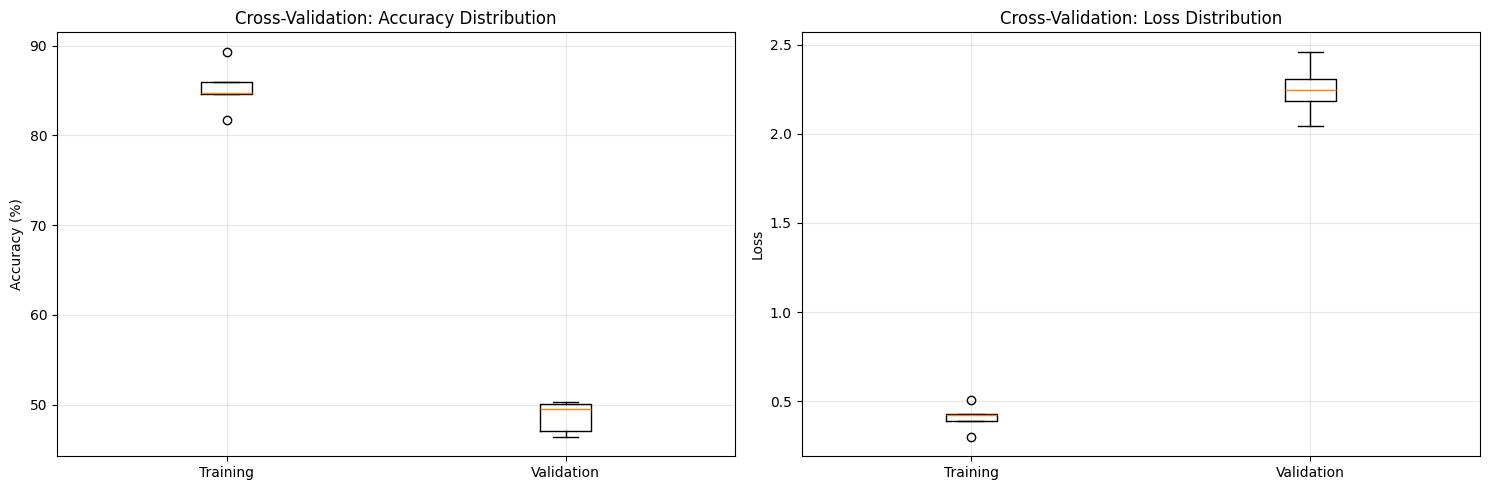

Cross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'


In [ ]:
# Cross-Validation für statistische Fehlerschätzung
print("=== Cross-Validation ===")

# Beste Hyperparameter aus dem Tuning verwenden
best_lr = best_config['Learning Rate']
best_batch = int(best_config['Batch Size'])

print(f"Verwende beste Konfiguration: LR={best_lr}, Batch={best_batch}")
print(f"WICHTIG: Alle Folds trainieren exakt 60 Epochen (Early Stopping deaktiviert)")
print("Dies stellt sicher, dass die statistische Vergleichbarkeit gewährleistet ist.")

# Cross-Validation durchführen
# Modell-Klasse wird als Parameter übergeben, Early Stopping ist deaktiviert
cv_results = cross_validation_training(
    train_dataset=full_train_dataset,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_folds=5,
    num_epochs=60,  # Konsistent mit Baseline-Training (Epoche 60 als Referenz)
    learning_rate=best_lr,
    batch_size=best_batch,
    img_size=img_size,
    num_classes=num_classes
)

print(f"\n=== Cross-Validation Ergebnisse (Mittelwert ± Standardabweichung) ===")
print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")

# F1-Scores ausgeben falls vorhanden
if 'train_f1s' in cv_results:
    print(f"Training F1-Score: {cv_results['train_f1s']['mean']:.4f} ± {cv_results['train_f1s']['std']:.4f}")
    print(f"Validation F1-Score: {cv_results['val_f1s']['mean']:.4f} ± {cv_results['val_f1s']['std']:.4f}")

print("\nInterpretation der Unsicherheiten:")
print("- Die Standardabweichung zeigt die Variabilität zwischen den 5 Folds.")
print("- Eine höhere Standardabweichung deutet auf größere Unsicherheit hin.")
print("- Mögliche Ursachen: Unterschiedliche Datenverteilungen in den Folds, Modell-Instabilität,")
print("  oder dass das Modell sehr empfindlich auf die Trainingsdaten reagiert.")

# Sicherstellen, dass das results Verzeichnis existiert
os.makedirs('results', exist_ok=True)

with open('results/cross_validation_results.json', 'w') as f:
    json.dump({
        'best_hyperparameters': {
            'learning_rate': best_lr,
            'batch_size': best_batch
        },
        'cv_results': cv_results,
        'num_epochs': 60,  # Dokumentation: Alle Folds trainierten 60 Epochen
        'note': 'Early Stopping wurde deaktiviert für konsistente Epochenanzahl'
    }, f, indent=2)

print("\nCross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'")
